<div style="display: flex; background-color: #3F579F;">
    <h1 style="margin: auto; font-weight: bold; padding: 30px 30px 0px 30px; color:#fff;" align="center">Implement a scoring model - P7</h1>
</div>
<div style="display: flex; background-color: #3F579F; margin: auto; padding: 5px 30px 0px 30px;" >
    <h3 style="width: 100%; text-align: center; float: left; font-size: 24px; color:#fff;" align="center">| Modeling Notebook |</h3>
</div>
<div style="display: flex; background-color: #3F579F; margin: auto; padding: 10px 30px 30px 30px;">
    <h4 style="width: 100%; text-align: center; float: left; font-size: 24px; color:#fff;" align="center">Data Scientist course - OpenClassrooms</h4>
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">1. Libraries</h2>
</div>

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">1.1 Libraries</h3>
</div>

In [1]:
## General
import re
import pandas as pd
import numpy as np

## Scikit Learn library
from sklearn.model_selection import train_test_split

## imbalanced-learn
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE

## Own specific functions 
from functions import *

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">2. Importing files</h2>
</div>

<div class="alert alert-block alert-info">
    <p>Let's load the current clients
   </p>
</div>

In [2]:
df_current_clients = pd.read_csv(r"datasets\finals_datasets\df_current_clients.csv", nrows=30000)

In [3]:
df_analysis(df_current_clients, "df_current_clients", analysis_type="header")


Analysis Header of df_current_clients dataset
--------------------------------------------------------------------------------
- Dataset shape:			 30000 rows and 509 columns
- Total of NaN values:			 0
- Percentage of NaN:			 0.0 %
- Total of infinite values:		 0
- Percentage of infinite values:	 0.0 %
- Total of full duplicates rows:	 0
- Total of empty rows:			 0
- Total of empty columns:		 0
- Unique indexes:			 True
- Memory usage:				 116.5 MB


<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>After making the preprocessing, we achieved 0.0% of missing-values.</p>
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">3. Optimizing memory usage</h2>
</div>

<div class="alert alert-block alert-warning">
    <p>We should optimize the memory usage to avoid problems during executions</p>
</div>

In [4]:
df_current_clients = memory_optimization(df_current_clients)

In [5]:
df_analysis(df_current_clients, "df", analysis_type="header")


Analysis Header of df dataset
--------------------------------------------------------------------------------
- Dataset shape:			 30000 rows and 509 columns
- Total of NaN values:			 0
- Percentage of NaN:			 0.0 %
- Total of infinite values:		 0
- Percentage of infinite values:	 0.0 %
- Total of full duplicates rows:	 0
- Total of empty rows:			 0
- Total of empty columns:		 0
- Unique indexes:			 True
- Memory usage:				 45.5 MB


<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>The memory usage has been reduced.</p>
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">4. Analyzing target variable</h2>
</div>

<div class="alert alert-block alert-info">
    <p>We are going to analyze the target variable to see whether is an imbalanced class
   </p>
</div>

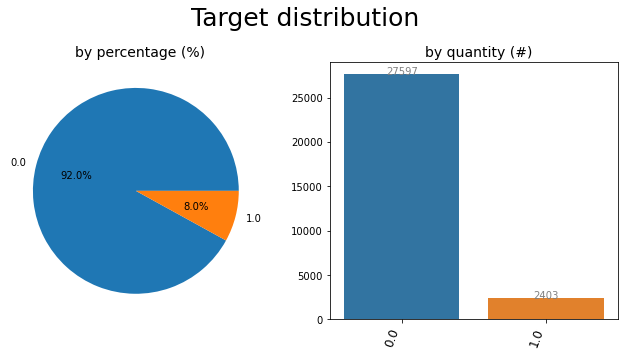

In [6]:
barplot_and_pie(df_current_clients["TARGET"], "Target distribution", " ")

<div class="alert alert-block alert-warning">
    <p><b>Observations / Conclusions</b></p>
    <ul style="list-style-type: square;">
        <li>Here we can see how much the dataset is imbalanced so, we are facing a imbalanced classification problem</li>
        <li>It is easily identifying that there are <b>loans that were repaid (0)</b> in comparison of <b>loans that were not repaid (1)</b>s</li>
        <li>We are going to treat the imbalanced class into a pipeline during the modeling</li>
    </ul> 
</div>

<div class="alert alert-block alert-danger">
    <p><b>FLAG</b>
   </p>
</div>

In [13]:
xxxxxxxxxxx

NameError: name 'xxxxxxxxxxx' is not defined

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">5. Splitting data</h2>
</div>

<div class="alert alert-block alert-info">
    <p>First of all, let's identify the training columns in the dataset
   </p>
</div>

In [29]:
NOT_TRAINING_COLUMNS  = ["TARGET", "SK_ID_CURR", "SK_ID_BUREAU", "SK_ID_PREV", "index"] 
TRAINING_COLUMNS = [col for col in df_current_clients.columns if col not in NOT_TRAINING_COLUMNS]

In [8]:
X = df_current_clients.drop(columns=["TARGET"])

In [9]:
y_target = df_current_clients.loc[:,"TARGET"]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y_target, test_size=0.20, random_state=42)

In [11]:
print("X_train: {}".format(X_train.shape))
print("y_train: {}".format(y_train.shape))
print("---------------------")
print("X_test: {}".format(X_test.shape))
print("y_test: {}".format(y_test.shape))

X_train: (24000, 508)
y_train: (24000,)
---------------------
X_test: (6000, 508)
y_test: (6000,)


<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">6. Modelisation</h2>
</div>

<div class="alert alert-block alert-warning">
    <p>We are going to use three models to compare </b></p>
    <ul style="list-style-type: square;">
        <li>Here we can see how much the dataset is imbalanced so, we are facing a imbalanced classification problem</li>
        <li>It is easily identifying that there are <b>loans that were repaid (0)</b> in comparison of <b>loans that were not repaid (1)</b>s</li>
        <li>We are going to treat the imbalanced class into a pipeline during the modeling</li>
    </ul> 
</div>

In [12]:
smote = SMOTE(sampling_strategy="auto", k_neighbors=5, n_jobs=-1,
              random_state=42)

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">6.1. LightGBM</h3>
</div>

In [13]:
xxxxxxxxxxx

NameError: name 'xxxxxxxxxxx' is not defined

<div class="alert alert-block alert-danger">
    <p>funciona
   </p>
</div>

<div class="alert alert-block alert-warning">
    <p><b>Observations / Conclusions</b></p>
    <ul style="list-style-type: square;">
        <li>NO se utilizo custom score</li>
        <li>Kfold de 5 y no stratified https://towardsdatascience.com/the-right-way-of-using-smote-with-cross-validation-92a8d09d00c7</li>
        <li>solo un parametro de prueba</li>
    </ul> 
</div>

In [ ]:
import lightgbm as lgb
from lightgbm import LGBMClassifier

In [ ]:
pipeline = imbpipeline(steps = [['Smote', smote],
                                ['LightGBM', LGBMClassifier()]])

In [ ]:
sorted(pipeline.get_params().keys())

In [ ]:
param_grid = {
    "LightGBM__n_estimators" : [8000, 10000, 12000], 
}

In [ ]:
from sklearn.model_selection import KFold, GridSearchCV

In [ ]:
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

In [ ]:
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           cv=kfold,
                           n_jobs=-1)

In [ ]:
grid_search.fit(X_train, y_train)

In [ ]:
cv_score = grid_search.best_score_

In [ ]:
test_score = grid_search.score(X_test, y_test)

In [ ]:
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

In [ ]:
grid_search.cv_results_

<div class="alert alert-block alert-danger">
    <p>funciona
   </p>
</div>

<div class="alert alert-block alert-danger">
    <p>PRUEBA 2
   </p>
</div>

<div class="alert alert-block alert-warning">
    <p><b>Observations / Conclusions</b></p>
    <ul style="list-style-type: square;">
        <li>NO se utilizo custom score</li>
        <li>Kfold de 3 y no stratified https://towardsdatascience.com/the-right-way-of-using-smote-with-cross-validation-92a8d09d00c7</li>
        <li>varios parametros de prueba</li>
        <li>return_train_score</li>
    </ul> 
</div>

In [14]:
import lightgbm as lgb
from lightgbm import LGBMClassifier

In [15]:
pipeline = imbpipeline(steps = [['Smote', smote],
                                ['LightGBM', LGBMClassifier(colsample_bytree=0.8,
                                                            subsample=0.8, is_unbalance=False,
                                                            n_jobs=-1)]])

In [16]:
sorted(pipeline.get_params().keys())

['LightGBM',
 'LightGBM__boosting_type',
 'LightGBM__class_weight',
 'LightGBM__colsample_bytree',
 'LightGBM__importance_type',
 'LightGBM__is_unbalance',
 'LightGBM__learning_rate',
 'LightGBM__max_depth',
 'LightGBM__min_child_samples',
 'LightGBM__min_child_weight',
 'LightGBM__min_split_gain',
 'LightGBM__n_estimators',
 'LightGBM__n_jobs',
 'LightGBM__num_leaves',
 'LightGBM__objective',
 'LightGBM__random_state',
 'LightGBM__reg_alpha',
 'LightGBM__reg_lambda',
 'LightGBM__silent',
 'LightGBM__subsample',
 'LightGBM__subsample_for_bin',
 'LightGBM__subsample_freq',
 'Smote',
 'Smote__k_neighbors',
 'Smote__n_jobs',
 'Smote__random_state',
 'Smote__sampling_strategy',
 'memory',
 'steps',
 'verbose']

In [17]:
param_grid = {
    "LightGBM__n_estimators" : [8000, 10000, 12000], 
}

In [18]:
from sklearn.model_selection import KFold, GridSearchCV

In [19]:
kfold = KFold(n_splits=3, shuffle=True, random_state=0)

In [20]:
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           cv=kfold,
                           n_jobs=-1, 
                           return_train_score=True)

In [21]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=3, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[['Smote',
                                        SMOTE(n_jobs=-1, random_state=42)],
                                       ['LightGBM',
                                        LGBMClassifier(colsample_bytree=0.8,
                                                       is_unbalance=False,
                                                       subsample=0.8)]]),
             n_jobs=-1,
             param_grid={'LightGBM__n_estimators': [8000, 10000, 12000]},
             return_train_score=True, scoring='roc_auc')

In [22]:
cv_score = grid_search.best_score_

In [23]:
test_score = grid_search.score(X_test, y_test)

In [24]:
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

Cross-validation score: 0.7183619427687655
Test score: 0.725741824097647


In [25]:
grid_search.cv_results_

{'mean_fit_time': array([653.90366872, 788.10708992, 678.03887987]),
 'std_fit_time': array([  6.17617837,  51.84937029, 205.28796609]),
 'mean_score_time': array([17.5763042 , 17.09792177, 13.7985216 ]),
 'std_score_time': array([0.47785925, 0.82988621, 4.6804792 ]),
 'param_LightGBM__n_estimators': masked_array(data=[8000, 10000, 12000],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'LightGBM__n_estimators': 8000},
  {'LightGBM__n_estimators': 10000},
  {'LightGBM__n_estimators': 12000}],
 'split0_test_score': array([0.71626533, 0.71605719, 0.71592379]),
 'split1_test_score': array([0.72114011, 0.72082608, 0.72091873]),
 'split2_test_score': array([0.71768039, 0.71751851, 0.71746112]),
 'mean_test_score': array([0.71836194, 0.71813392, 0.71810121]),
 'std_test_score': array([0.00204764, 0.00199493, 0.0020888 ]),
 'rank_test_score': array([1, 2, 3]),
 'split0_train_score': array([1., 1., 1.]),
 'split1_train_score': array([1

In [26]:
print("- Parameters:", grid_search.best_params_)

- Parameters: {'LightGBM__n_estimators': 8000}


In [27]:
# Transforming the result to dataframe format
df_results = pd.DataFrame(grid_search.cv_results_)

In [28]:
print("- Duration:", round(df_results.iloc[grid_search.best_index_]["mean_score_time"], 3))

- Duration: 17.576


<div class="alert alert-block alert-success">
    <p><b>OK</b></p>
</div>

<div class="alert alert-block alert-danger">
    <p>PRUEBA 2
   </p>
</div>

<div class="alert alert-block alert-danger">
    <p>PRUEBA HYPEROPT
   </p>
</div>

In [ ]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from hyperopt.pyll.base import scope

from functools import partial

In [ ]:
# Hyperparametrization
#from hyperopt import tpe, hp, fmin, STATUS_OK, Trials, space_eval
#from hyperopt.pyll.base import scope

<div class="alert alert-block alert-danger">
    <p>PRUEBA HYPEROPT
   </p>
</div>

<div class="alert alert-block alert-danger">
    <p>PRUEBA 3<br>greater_is_betterbool, default=True
   </p>
</div>

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
def custom_score(y_true, y_pred):
    """
    Method used to calculate a score based on the penalization of False Negatives.

    Parameters:
    -----------------
        y_true (series): True values
        y_pred (series): Predicted values
        
    Returns:
    -----------------
        Score. (float): Score obtained based on the rules defined to measure. 
    """
    
    # Getting the probability outputs from "predict_proba"
    threshold = 0.5
    y_pred = (y_pred >= threshold).astype(int)
    
    TN_rate = 1        # Loans that are not in default and were predicted correctly
    TP_rate = 1        # Loans that are in default and were predicted correctly
    FP_rate = 0        # Loans that are not in default and were predicted incorrectly
    FN_rate = -10      # Loans that are in default and were were predicted incorrectly
    
    # Getting all values based on confusion matrix
    (TN, FP, FN, TP) = confusion_matrix(y_true, y_pred).ravel()

    # Total of default and not default cases
    total_not_default = TN + FP     # Not default cases
    total_default = TP + FN         # Default cases 
    
    gain_total = TN*TN_rate + TP*TP_rate + FP*FP_rate + FN*FN_rate
    gain_maximun = total_not_default*TN_rate + total_default*TP_rate
    gain_minumun = total_not_default*TN_rate + total_default*FN_rate
    
    # normalize to get score between 0 (baseline) and 1
    score = (gain_total - gain_minumun) / (gain_maximun - gain_minumun)
    
    return score

In [ ]:
from sklearn.metrics import make_scorer

In [ ]:
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring=make_scorer(custom_score),
                           cv=kfold,
                           n_jobs=-1, 
                           return_train_score=True)

In [ ]:
grid_search.fit(X_train, y_train)

In [ ]:
cv_score = grid_search.best_score_

In [ ]:
test_score = grid_search.score(X_test, y_test)

In [ ]:
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

In [ ]:
grid_search.cv_results_

In [ ]:
print("- Parameters:", grid_search.best_params_)

In [ ]:
# Transforming the result to dataframe format
df_results = pd.DataFrame(grid_search.cv_results_)

In [ ]:
print("- Duration:", round(df_results.iloc[grid_search.best_index_]["mean_score_time"], 3))

<div class="alert alert-block alert-danger">
    <p>PRUEBA 3
   </p>
</div>

<div class="alert alert-block alert-danger">
    <p>PRUEBA 4<br>greater_is_betterbool, default=False
   </p>
</div>

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
def custom_score(y_true, y_pred):
    """
    Method used to calculate a score based on the penalization of False Negatives.

    Parameters:
    -----------------
        y_true (series): True values
        y_pred (series): Predicted values
        
    Returns:
    -----------------
        Score. (float): Score obtained based on the rules defined to measure. 
    """
    
    # Getting the probability outputs from "predict_proba"
    threshold = 0.5
    y_pred = (y_pred >= threshold).astype(int)
    
    TN_rate = 1        # Loans that are not in default and were predicted correctly
    TP_rate = 1        # Loans that are in default and were predicted correctly
    FP_rate = 0        # Loans that are not in default and were predicted incorrectly
    FN_rate = -10      # Loans that are in default and were were predicted incorrectly
    
    # Getting all values based on confusion matrix
    (TN, FP, FN, TP) = confusion_matrix(y_true, y_pred).ravel()

    # Total of default and not default cases
    total_not_default = TN + FP     # Not default cases
    total_default = TP + FN         # Default cases 
    
    gain_total = TN*TN_rate + TP*TP_rate + FP*FP_rate + FN*FN_rate
    gain_maximun = total_not_default*TN_rate + total_default*TP_rate
    gain_minumun = total_not_default*TN_rate + total_default*FN_rate
    
    # normalize to get score between 0 (baseline) and 1
    score = (gain_total - gain_minumun) / (gain_maximun - gain_minumun)
    
    return score

In [ ]:
from sklearn.metrics import make_scorer

In [ ]:
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring=make_scorer(custom_score, greater_is_better=False),
                           cv=kfold,
                           n_jobs=-1, 
                           return_train_score=True)

In [ ]:
grid_search.fit(X_train, y_train)

In [ ]:
cv_score = grid_search.best_score_

In [ ]:
test_score = grid_search.score(X_test, y_test)

In [ ]:
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

In [ ]:
grid_search.cv_results_

In [ ]:
print("- Parameters:", grid_search.best_params_)

In [ ]:
# Transforming the result to dataframe format
df_results = pd.DataFrame(grid_search.cv_results_)

In [ ]:
print("- Duration:", round(df_results.iloc[grid_search.best_index_]["mean_score_time"], 3))

<div class="alert alert-block alert-danger">
    <p>PRUEBA 4
   </p>
</div>

<div class="alert alert-block alert-danger">
    <p>PRUEBA 5<br>greater_is_betterbool, default=False
   </p>
</div>

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
def custom_score(y_true, y_pred):
    """
    Method used to calculate a score based on the penalization of False Negatives.

    Parameters:
    -----------------
        y_true (series): True values
        y_pred (series): Predicted values
        
    Returns:
    -----------------
        Score. (float): Score obtained based on the rules defined to measure. 
    """
    
    # Getting the probability outputs from "predict_proba"
    threshold = 0.5
    y_pred = (y_pred >= threshold).astype(int)
    
    TN_rate = 1        # Loans that are not in default and were predicted correctly
    TP_rate = 1        # Loans that are in default and were predicted correctly
    FP_rate = 0        # Loans that are not in default and were predicted incorrectly
    FN_rate = -10      # Loans that are in default and were were predicted incorrectly
    
    # Getting all values based on confusion matrix
    (TN, FP, FN, TP) = confusion_matrix(y_true, y_pred).ravel()

    # Total of default and not default cases
    total_not_default = TN + FP     # Not default cases
    total_default = TP + FN         # Default cases 
    
    gain_total = TN*TN_rate + TP*TP_rate + FP*FP_rate + FN*FN_rate
    gain_maximun = total_not_default*TN_rate + total_default*TP_rate
    gain_minumun = total_not_default*TN_rate + total_default*FN_rate
    
    # normalize to get score between 0 (baseline) and 1
    score = (gain_total - gain_minumun) / (gain_maximun - gain_minumun)
    
    return score

In [ ]:
from sklearn.metrics import make_scorer

In [ ]:
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring="average_precision",
                           cv=kfold,
                           n_jobs=-1, 
                           return_train_score=True)

In [ ]:
grid_search.fit(X_train, y_train)

In [ ]:
cv_score = grid_search.best_score_

In [ ]:
test_score = grid_search.score(X_test, y_test)

In [ ]:
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

In [ ]:
grid_search.cv_results_

In [ ]:
print("- Parameters:", grid_search.best_params_)

In [ ]:
# Transforming the result to dataframe format
df_results = pd.DataFrame(grid_search.cv_results_)

In [ ]:
print("- Duration:", round(df_results.iloc[grid_search.best_index_]["mean_score_time"], 3))

<div class="alert alert-block alert-danger">
    <p>PRUEBA 3
   </p>
</div>

In [ ]:
folds = KFold(n_splits=2, shuffle=True, random_state=42)

In [ ]:
# Create arrays and dataframes to store results
oof_preds = np.zeros(df_current_clients.shape[0])
feats = [f for f in df_current_clients.columns if f not in ["TARGET", "SK_ID_CURR", "SK_ID_BUREAU", "SK_ID_PREV"]]

In [ ]:
pipeline = imbpipeline(steps = [
        ['Smote', smote],
        ['LightGBM', LGBMClassifier(colsample_bytree=0.8, subsample=0.8, 
                                    is_unbalance=False, n_jobs=-1)]
    ]
)

In [ ]:
sorted(pipeline.get_params().keys())

In [ ]:
param_grid = {
    "LightGBM__n_estimators" : [8000, 10000, 12000], 
}

In [ ]:
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(df_current_clients[feats], df_current_clients["TARGET"])):
    
    print("\n")
    
    train_x, train_y = df_current_clients[feats].iloc[train_idx], df_current_clients["TARGET"].iloc[train_idx]
    valid_x, valid_y = df_current_clients[feats].iloc[valid_idx], df_current_clients["TARGET"].iloc[valid_idx]
    
    # LightGBM parameters found by Bayesian optimization
    clf = LGBMClassifier(
        **space_params,
        colsample_bytree=0.8, 
        subsample=0.8,
        is_unbalance=False,
        n_jobs=-1 
    )    

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">6.2. SVB</h3>
</div>

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">6.3. RAndom Forest</h3>
</div>